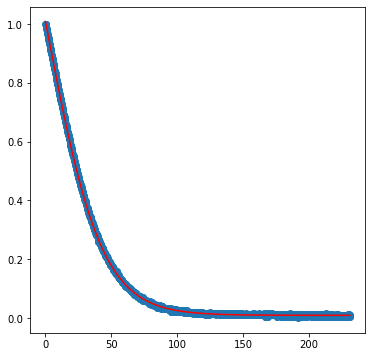

In [26]:
# 参考　https://kunassy.com/python-curve_fit/
# ファイルを選んで処理

%matplotlib widget
import matplotlib
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import os
from ipywidgets import Output
from scipy.optimize import curve_fit
import seaborn as sns
%matplotlib inline

# TODO Aは定数にしたい

def kinetic_model_f1(x, B, C, D):
    A = 1
    return A*(1-((1-np.exp(D*x))/(1-C*np.exp(D*x)))) + B

file_path = "result/20220909 5HB/30/30 25 490.csv"
file_name = file_path.split("/")[-1].split(".")[0]
df_result = pd.read_csv(file_path)
df_result = df_result.rename(
    columns={"time " + file_name: "time", "abs " + file_name: "abs"}
)
result_dir = file_path.split(file_name)[0] + "fit_result/"

x = df_result['time'] - df_result['time'][0]
y = (df_result['abs'] - min(df_result['abs'])) / (max(df_result['abs']) - min(df_result['abs']))

data_kinetic_model_f1 = np.array([x, y])

param_init_dict = {
        "data_kinetic_model_f1":[0, 0.6, -0.01]
        }
# グラフ描画用のサンプルデータ
sample_x = np.array(x)


def fit(func, x, param_init):
    """
    func:データxに近似したい任意の関数
    x:データ
    param_init:パラメータの初期値
    popｔ:最適化されたパラメータ
    pocv:パラメータの共分散
    """
    X = x[0]
    Y = x[1]
    popt,pocv=curve_fit(func, X, Y, p0=param_init)
    perr = np.sqrt(np.diag(pocv)) #対角成分が各パラメータの標準誤差に相当
    y=func(sample_x, *popt)
    return y, popt, perr


fit_result = fit(kinetic_model_f1, data_kinetic_model_f1, param_init_dict["data_kinetic_model_f1"])
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.scatter(data_kinetic_model_f1[0], data_kinetic_model_f1[1])
ax.plot(sample_x, fit_result[0], color="red")




In [27]:
opt_B = fit_result[1][0]
opt_C = fit_result[1][1]
opt_D = fit_result[1][2]

k_1 = -opt_D
k_2 = -(opt_C * opt_D)/(1 - opt_C)

column_name = file_name

# 測定条件の入力を詳細に行いたい場合
# temp = 30
# wavelength = 490
# filter_combination_list = ["001", "010", "011", "100", "101", "110"]
# period_3 = 25
# filter_combination = filter_combination_list[1]

# if 'period_3' in locals():
#     column_name = str(temp) + " " + str(period_3) + " " + str(wavelength) + " " + filter_combination
# else:
#     column_name = str(temp) + " " + str(wavelength) + " " + filter_combination
    
opt_columns = ["opt_B", "opt_C", "opt_D", "k_1", "k_2"]
opt_params = np.array([opt_B, opt_C, opt_D, k_1, k_2])

df_opt_params = pd.DataFrame(opt_params, index=opt_columns, columns=[column_name])

df_opt_params

,30 25 490
opt_B,0.009008
opt_C,-1.084930
opt_D,-0.048472
k_1,0.048472
k_2,-0.025224


In [29]:
# fit_resultフォルダに保存し、最後に結合したCSVを出力
os.makedirs(result_dir, exist_ok=True)
df_opt_params.to_csv(result_dir + column_name + ".csv", index=True)

# ファイルの結合

In [42]:
# fit_resultフォルダに保存されたcsvファイルの結合、保存
import glob
import codecs

df_opt_params_all = pd.DataFrame()
data_dir = result_dir + "*.csv"
# 手動
# data_dir = ""
paths = [p for p in glob.glob(data_dir)]

for path in paths:
    with codecs.open(path, "r", "UTF-8", "ignore") as file:
        df = pd.read_csv(file)
        df = df.rename(
            columns={df.columns[0]: "params"}
        )
        df = df.set_index("params")
        df_opt_params_all = pd.concat([df_opt_params_all, df], axis=1)

        
os.makedirs(result_dir + "concat", exist_ok=True)
# 保存
df_opt_params_all.to_csv(result_dir + "concat/df_opt_params_all.csv", index=True)